### Team Members: 
- Rajan Ghimire : Student ID : C0924991
- Prajwal Luitel : Student ID : C0927658

### Creating a Dummy Data 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings(action="ignore")
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import auc, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

X, y = make_classification(
    n_samples=2000, n_features=4, n_redundant=0, n_informative=4, random_state=42
)

feature_names = [
    "text_length",
    "avg_word_length",
    "exclamation_count",
    "question_mark_count",
]
X_df = pd.DataFrame(X, columns=feature_names)

X_df["sentiment_score"] = np.random.choice([0, 1], size=2000)

df = X_df.copy()
df["target"] = y




### Basic EDA on Dummy Data

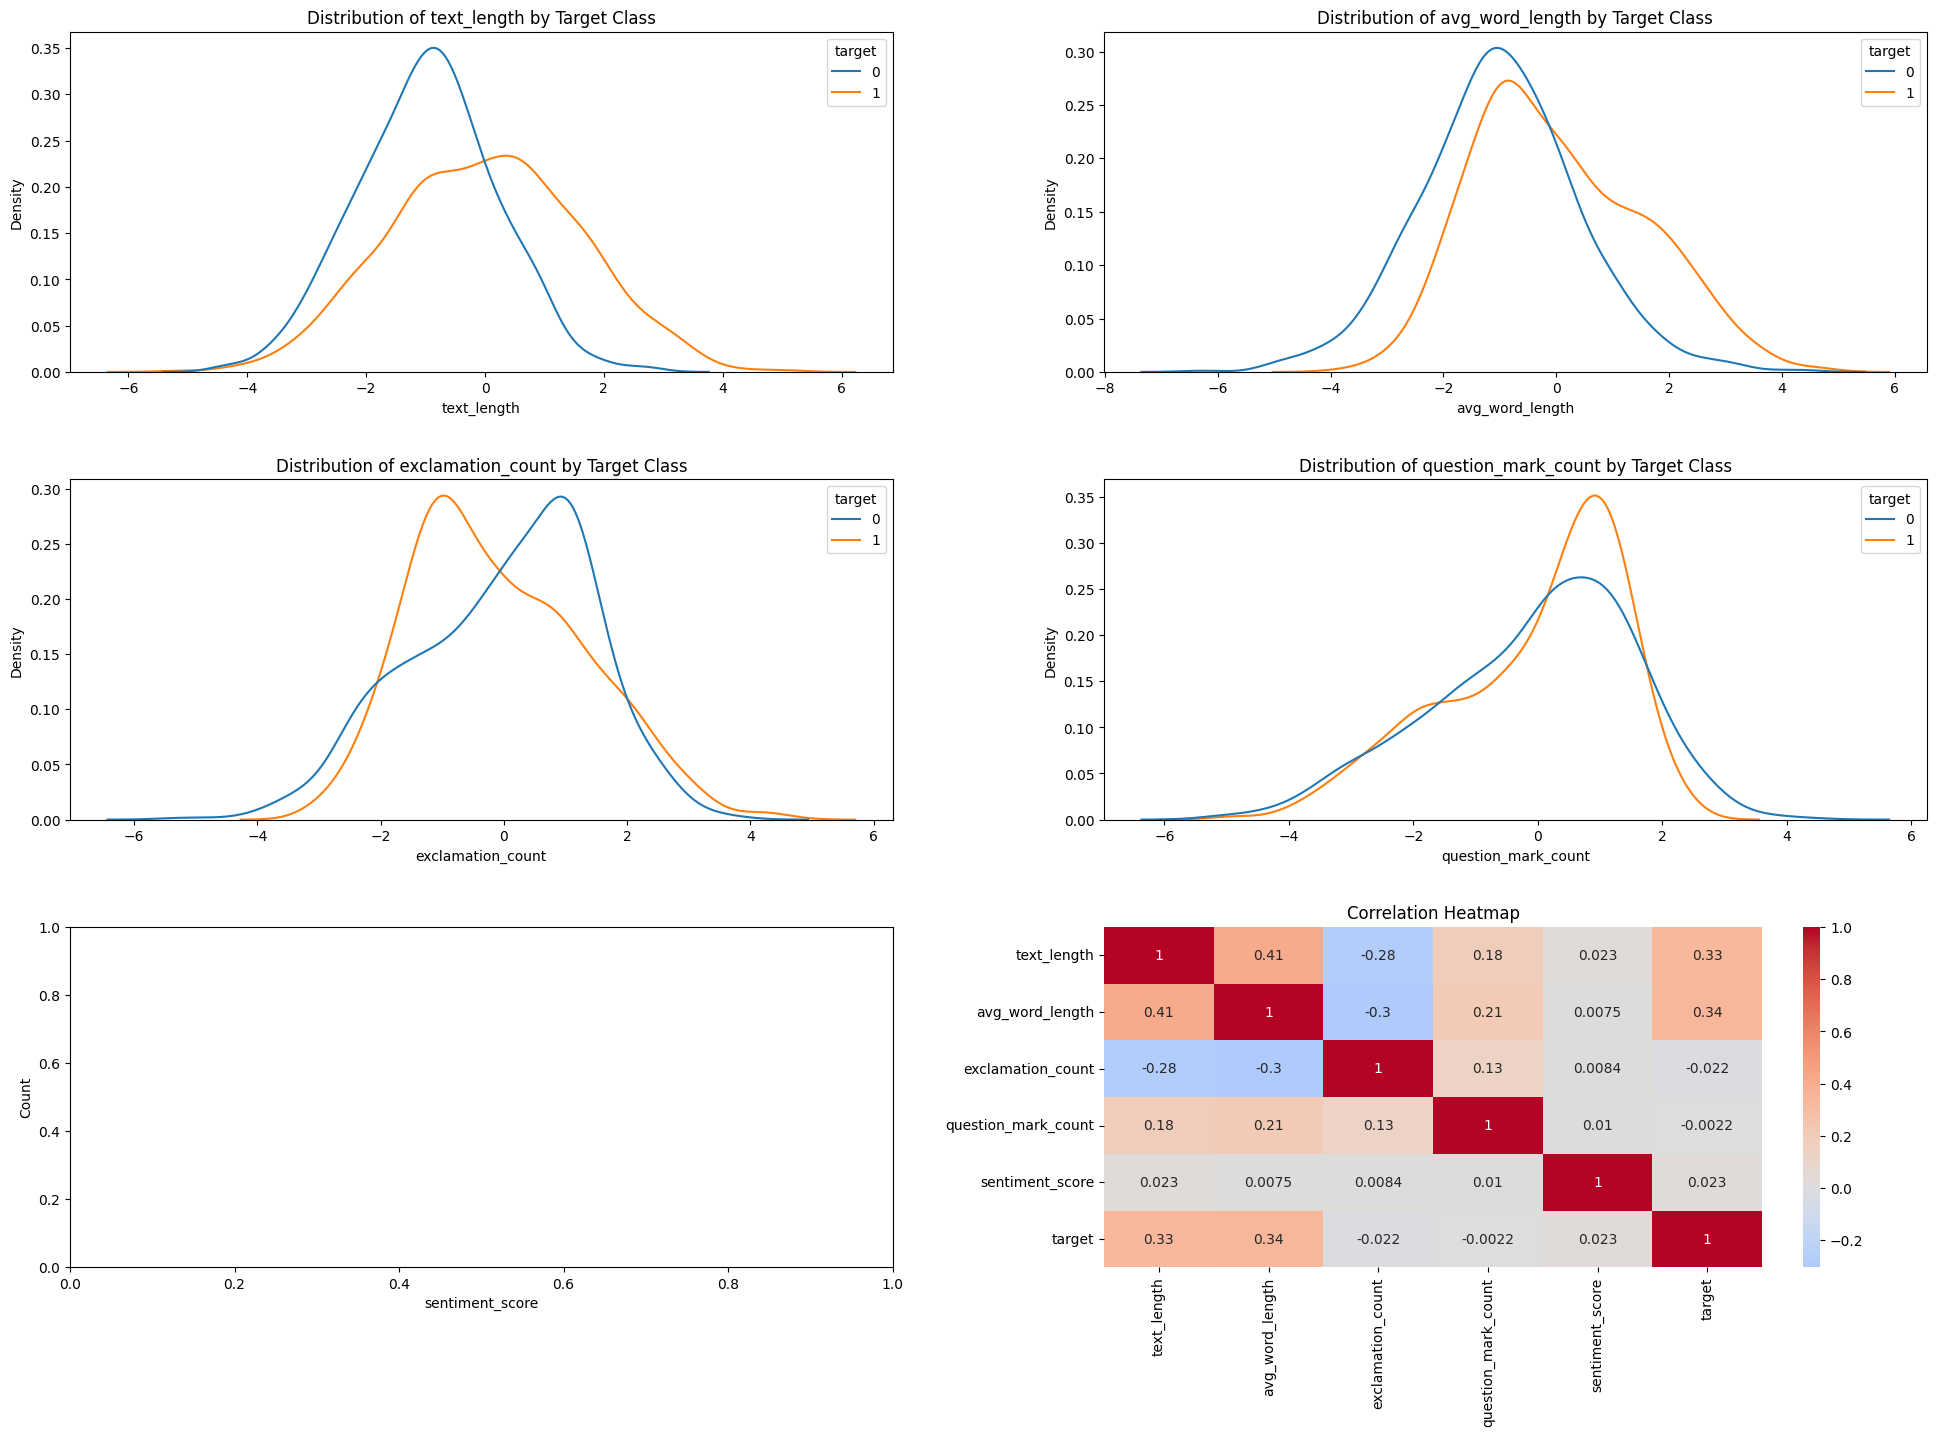

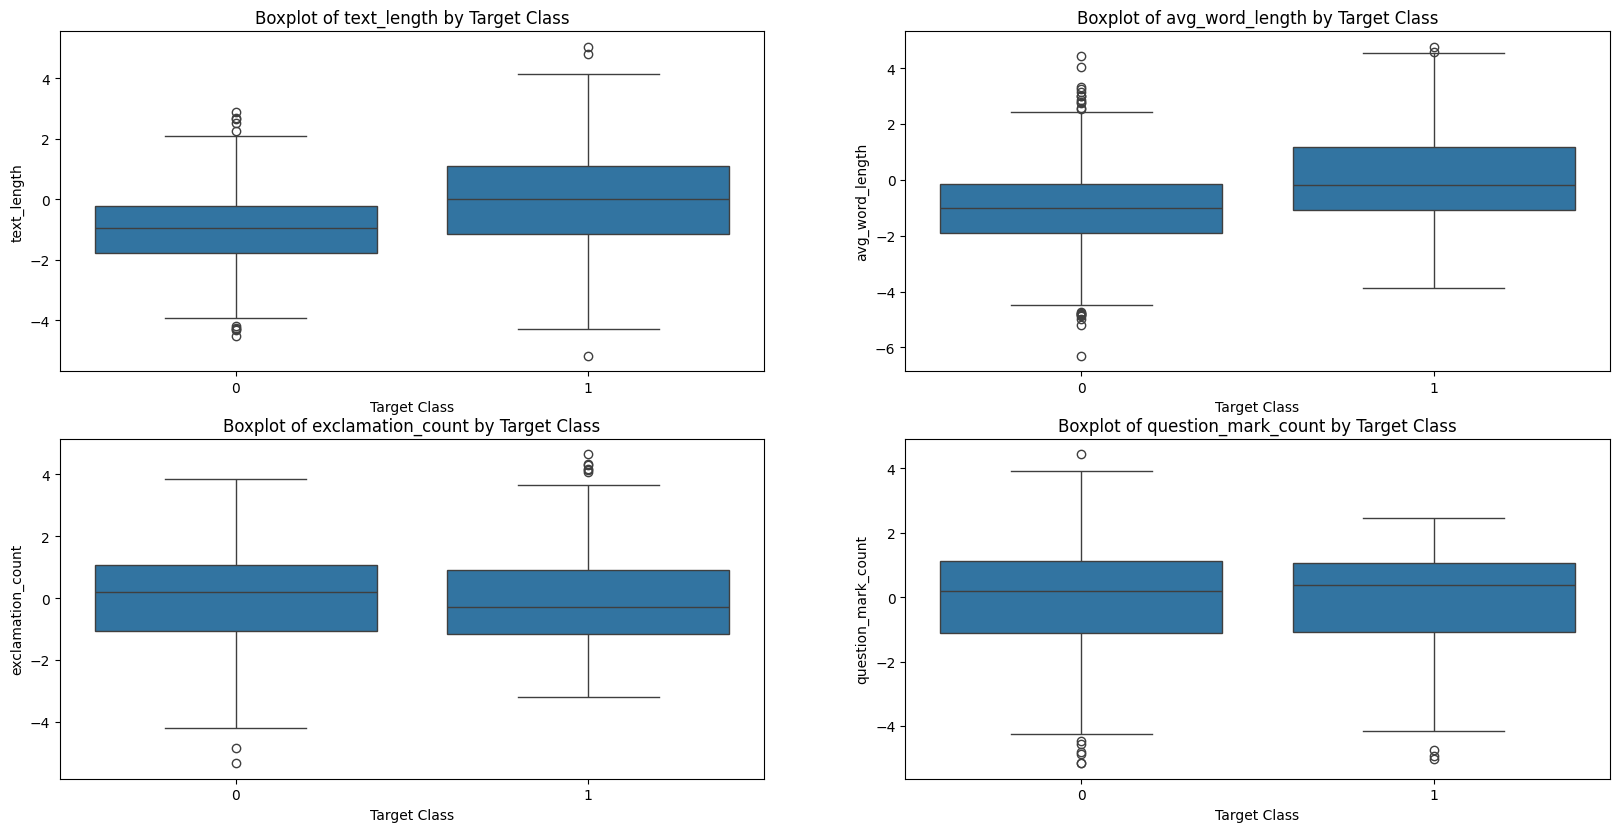

In [2]:

#####################Distribution plots###############################
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names + ["sentiment_score"], 1):
    plt.subplot(3, 2, i)
    if feature != "sentiment_score":
        sns.kdeplot(data=df, x=feature, hue="target", common_norm=False)
        plt.title(f"Distribution of {feature} by Target Class")
    plt.xlabel(feature)
    plt.ylabel("Count" if feature == "sentiment_score" else "Density")


#####################Correlation heatmap###############################

plt.subplot(3, 2, 6)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout(pad=3.0)
plt.show()

##################### 2. Box plots #####################
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x="target", y=feature)
    plt.title(f"Boxplot of {feature} by Target Class")
    plt.xlabel("Target Class")
    plt.ylabel(feature)



In [3]:
##################### Additioanl Stats #####################
print("\nSkewness:")
print(df[feature_names + ["sentiment_score"]].skew())

print("\nKurtosis:")
print(df[feature_names + ["sentiment_score"]].kurtosis())

print("\nClass Distribution:")
print(df["target"].value_counts(normalize=True))

# Feature importance
mi_scores = mutual_info_classif(df[feature_names + ["sentiment_score"]], df["target"])
mi_df = pd.DataFrame(
    {"Feature": feature_names + ["sentiment_score"], "Mutual Information": mi_scores}
)
mi_df = mi_df.sort_values("Mutual Information", ascending=False)

print("\nFeature Importance (Mutual Information):")
print(mi_df)



Skewness:
text_length            0.259552
avg_word_length        0.278491
exclamation_count      0.001084
question_mark_count   -0.607068
sentiment_score        0.032028
dtype: float64

Kurtosis:
text_length            0.010508
avg_word_length        0.203495
exclamation_count     -0.338542
question_mark_count   -0.120072
sentiment_score       -2.000976
dtype: float64

Class Distribution:
target
1    0.5005
0    0.4995
Name: proportion, dtype: float64

Feature Importance (Mutual Information):
               Feature  Mutual Information
1      avg_word_length            0.073974
0          text_length            0.050753
2    exclamation_count            0.034641
4      sentiment_score            0.010872
3  question_mark_count            0.007905


### Data preparation for traning + training

In [4]:


X = df[feature_names + ["sentiment_score"]]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def calculate_woe_bins(data, target, feature, n_bins=10):
    if len(data[feature].unique()) <= 2:  # For binary features
        optb = OptimalBinning(name=feature, dtype="categorical", solver="cp")
    else:  # For continuous features
        optb = OptimalBinning(
            name=feature, dtype="numerical", solver="cp"
        )
    optb.fit(data[feature], target)
    binning_table = optb.binning_table.build()
    return optb, binning_table


woe_tables = []
binning_objects = []

for feature in feature_names + ["sentiment_score"]:
    optb, binning_table = calculate_woe_bins(X_train, y_train, feature)
    woe_tables.append(binning_table)
    binning_objects.append(optb)


X_train_woe = X_train.copy()
X_test_woe = X_test.copy()

for i, feature in enumerate(feature_names + ["sentiment_score"]):
    X_train_woe[feature] = binning_objects[i].transform(X_train[feature], metric="woe")
    X_test_woe[feature] = binning_objects[i].transform(X_test[feature], metric="woe")



In [5]:
# Random Forest with RandomizedSearchCV
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [10, 20, 30, 40, 50, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"],
}

################# With WOE #############################
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    random_state=42,
    n_jobs=-1,
)
rf_random.fit(X_train_woe, y_train)

################# With out WOE #############################

best_params = rf_random.best_params_
rf_no_woe = RandomForestClassifier(**best_params, random_state=42)
rf_no_woe.fit(X_train, y_train)



RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=500,
                       random_state=42)

### Results and comparasion

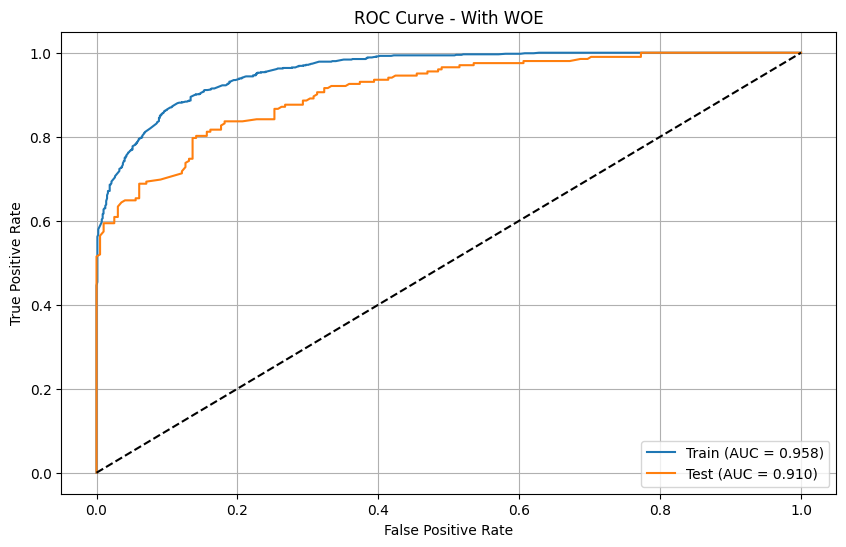

Classification Report - With WOE
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       198
           1       0.84      0.81      0.82       202

    accuracy                           0.82       400
   macro avg       0.83      0.83      0.82       400
weighted avg       0.83      0.82      0.82       400



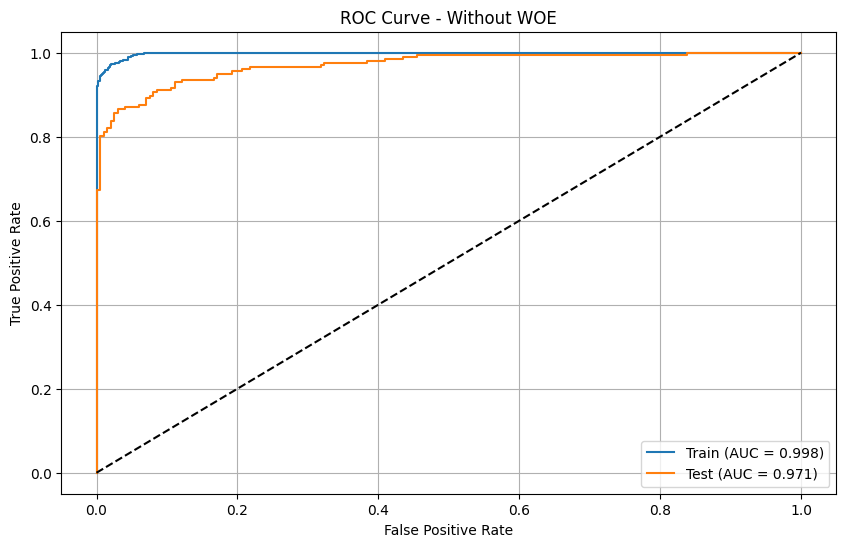

Classification Report - Without WOE
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       198
           1       0.92      0.89      0.91       202

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

WOE Tables:
WOE Table for text_length:
                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, -1.26)    493   0.308125        316    177    0.359026   
1       [-1.26, -0.44)    381   0.238125        232    149    0.391076   
2       [-0.44, -0.20)     96   0.060000         56     40    0.416667   
3        [-0.20, 0.44)    229   0.143125        109    120    0.524017   
4         [0.44, 0.96)    147   0.091875         53     94    0.639456   
5         [0.96, 1.39)     84   0.052500         22     62    0.738095   
6         [1.39, 1.97)     84   0.052500          8     76    0.904762   
7     

In [6]:

def plot_roc_curves(model, X_train, X_test, y_train, y_test, title):
    plt.figure(figsize=(10, 6))

    # in the training set
    y_train_pred = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, label=f"Train (AUC = {auc_train:.3f})")

    # on the test set
    y_test_pred = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f"Test (AUC = {auc_test:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend()
    plt.grid(True)
    plt.show()


    print(f"Classification Report - {title}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


plot_roc_curves(
    rf_random.best_estimator_, X_train_woe, X_test_woe, y_train, y_test, "With WOE"
)
plot_roc_curves(rf_no_woe, X_train, X_test, y_train, y_test, "Without WOE")

# Print WOE tables
print("WOE Tables:")
for i, feature in enumerate(feature_names + ["sentiment_score"]):
    print(f"WOE Table for {feature}:")
    print(woe_tables[i])
